In [4]:
import pandas as pd
import numpy as np
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from IPython.display import display
from geopy.distance import geodesic
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%load_ext autoreload
%autoreload 2

In [5]:
ratings = pd.read_csv('dataset/FilteredData/ratings.csv')

In [6]:
users = pd.read_csv('dataset/FilteredData/users.csv')

In [54]:
#Rewrite helper function to get the difference with the global mean and diffrence with global percentage

def location_style_stats(ratings, users, year,loc_style_threshold, do_ratings=False ):
    year_filter = ratings['year'] == year
    ratings = ratings.loc[year_filter]
    
    ratings = pd.merge(ratings, users[['user_id', 'nbr_ratings', 'location']], on='user_id', how='inner')

    ratings_groupedby_loc_style = ratings.groupby(['location', 'style'])
    ratings_style = ratings.groupby("style")
    total_nb = len(ratings)
    
    location_style = ratings_groupedby_loc_style.size().reset_index(name='number')
    ratings_groupedby_loc = ratings.groupby('location')
    ratings_loc = ratings_groupedby_loc.size().reset_index(name='total_loc_number')

    #Get the counts for each style globally
    
    style_counts = ratings['style'].value_counts()
    global_style = pd.DataFrame({'style': style_counts.index, 'total_number': style_counts.values})
   
    global_style['percentage'] = 100* (global_style['total_number'] / total_nb)
    
    ratings_loc['location_mean'] = ratings_groupedby_loc['rating'].mean().reset_index(name='location_mean')[
        'location_mean']
    ratings_loc['location_std'] = ratings_groupedby_loc['rating'].std().reset_index(name='location_std')[
        'location_std']
    ratings_loc['location_std'] = ratings_loc['location_std'].fillna(1)
    
    ratings_global = pd.DataFrame()
    ratings_global['global_mean'] = ratings_style['rating'].mean()
    ratings_global = ratings_global.reset_index()
   
  
    if (do_ratings):
        ratings_loc['normalized_rating'] = ratings.apply(lambda row: row['rating'] - ratings_global.loc[(ratings_global['style'] == row['style'])]['global_mean'].values[0], axis = 1)
    
    location_style = pd.merge(location_style, ratings_loc, on='location', how='inner')

    location_style['popularity_percentage'] = 100 * (location_style['number'] / location_style['total_loc_number'])

   

    #> 0 if more popular than global
    location_style['difference_percentage'] = location_style.apply(lambda row: row['popularity_percentage'] - global_style.loc[(global_style['style'] == row['style'])]['percentage'].values[0], axis = 1)
    
    location_style['mean_rating'] = ratings_groupedby_loc_style['rating'].mean().reset_index(name='mean_rating')['mean_rating']
    if (do_ratings):
        location_style = location_style[
        ['location', 'style', 'number', 'total_loc_number', 'popularity_percentage', 'mean_rating', 'location_mean',
         'location_std', 'difference_percentage', 'normalized_rating']]
    else: 
        location_style = location_style[
        ['location', 'style', 'number', 'total_loc_number', 'popularity_percentage', 'mean_rating', 'location_mean',
         'location_std', 'difference_percentage']]

    location_style['z_score'] = (location_style['mean_rating'] - location_style['location_mean']) / location_style[
        'location_std']
    location_style = location_style[location_style['number'] >= loc_style_threshold]

    return location_style

In [55]:
years = np.arange(2006, 2018)

#Change the threshold if needed
threshold = 5
all_infos = pd.DataFrame()
for year in years:
    infos = location_style_stats(ratings.copy(), users.copy(), year, threshold, True)
    print(infos.head())
    infos['year']=year
    all_infos = pd.concat([all_infos, infos], axis = 0)
    print(all_infos)


    location               style  number  total_loc_number  \
0  Australia        Abbey Dubbel      11               856   
1  Australia        Abbey Tripel      15               856   
2  Australia       Abt/Quadrupel       7               856   
3  Australia           Amber Ale      16               856   
4  Australia  Amber Lager/Vienna      10               856   

   popularity_percentage  mean_rating  location_mean  location_std  \
0               1.285047     0.057760      -0.405756      1.191329   
1               1.752336     0.403658      -0.405756      1.191329   
2               0.817757     1.224202      -0.405756      1.191329   
3               1.869159    -0.610433      -0.405756      1.191329   
4               1.168224    -0.815467      -0.405756      1.191329   

   difference_percentage  normalized_rating   z_score  
0              -0.201763           0.391069  0.389075  
1              -0.507399           0.391069  0.679421  
2              -0.288851           0.3

In [88]:
#Save the data to avoid re-reunning the code
#all_infos.to_csv('dataset/FilteredData/location_style_stats.csv', index=True)

In [128]:
#Function to compute the stats for each year (preferred style for the metric inspected, for each year)

def compute_yearly_stats(mean_diff_thr,metric_inspected, do_thr = False, study_ratings = False):
    years = np.arange(2006, 2018)

    yearly_stats = pd.DataFrame()
    for year in years:
        location_style = all_infos
        location_style = location_style.loc[location_style['year'] == year]
       
        if (do_thr):
            if(study_ratings):
                location_style = location_style.loc[location_style['normalized_rating'] > mean_diff_thr]
            else:
                location_style = location_style.loc[location_style['difference_percentage'] > mean_diff_thr]

        
        location_style_groupedby_loc = location_style.groupby('location')
        idx_most_popular = location_style_groupedby_loc[metric_inspected].idxmax()
        most_popular_styles_by_location = location_style.loc[idx_most_popular]
        if (study_ratings):
            most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'normalized_rating']]
            most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'normalized_rating': 'diff_rating-'+str(year)})
    
        else:
            most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
            most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})
    
        most_popular_styles_by_location.set_index('location', inplace = True)
        most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
        
        yearly_stats = pd.concat([yearly_stats, most_popular_styles_by_location], axis = 1)
        


    return yearly_stats




In [147]:
#Input: yearly_stats: dataframe with the most popular style by location for each year
#columns: colmuns (years) to be considered
def plot_trend_nb(stat_df, columns): 
    preferred_style = stat_df[columns].apply(lambda x: x.value_counts())
    popular = preferred_style[columns].loc[preferred_style[columns][preferred_style > 5].any(axis=1)]
    popular.T.plot()

Number of ratings for beer styles

In [106]:
#Trend = most different from the global mean

popularity_by_difference = compute_yearly_stats(0,'difference_percentage', False)

In [104]:
#Put for the most popular style (computed with the number of ratings) the distance to the global mean

style_popularities_by_year = compute_yearly_stats(0,'number', False)

<Axes: >

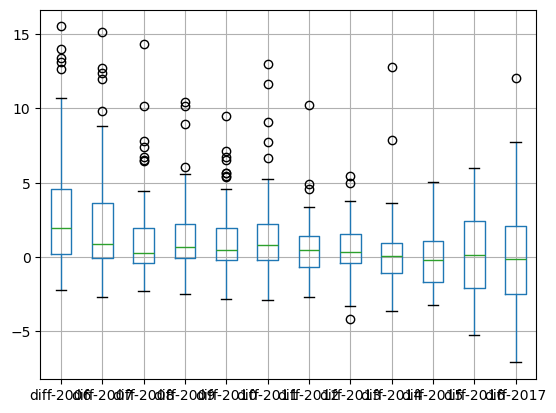

In [107]:
#Plot boxplot of the difference with global mean for each year, with preferred style (no threshold)
diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('diff')]
style_popularities_by_year[diff_columns].boxplot()


We can observe that without threshold, the percentage of ratings for the preferred style gets closer to the global mean

In [111]:
#Let's look at the difference between the obtained preferred styles with the two techniques

#select columns of style_popularities_by_year that don't start with diff
no_diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('2')]

#Table with True if the value is the same between style_popularities_by_year and popularity_by_difference for columns with same name
#False if different
(popularity_by_difference[no_diff_columns] == style_popularities_by_year[no_diff_columns])

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
location,,,,,,,,,,,,
Australia,True,True,True,True,False,False,False,False,False,False,False,False
Canada,True,True,False,False,False,False,False,False,False,False,False,False
England,True,True,False,True,True,True,True,False,False,False,False,False
Germany,False,False,True,True,False,False,False,False,True,False,False,False
Italy,False,True,True,True,True,True,False,False,True,False,False,False
Netherlands,True,True,False,True,False,False,False,False,False,False,True,True
Northern Ireland,True,True,False,False,False,True,False,False,False,False,True,True
Scotland,True,False,True,True,False,True,False,False,False,False,False,False
Sweden,True,True,True,False,True,True,False,False,False,False,False,False


In [112]:
no_diff_columns = [col for col in style_popularities_by_year.columns if col.startswith('2')]

In [133]:
test=  compute_yearly_stats(0,'number', do_thr = True,  study_ratings = False)

In [137]:
#Try different thresholds for the difference with the global mean
style_popularities_by_year_thr0=  compute_yearly_stats(0,'number', do_thr = True,  study_ratings = False)
style_popularities_by_year_thr05=  compute_yearly_stats(0.5,'number', do_thr = True,  study_ratings = False)
style_popularities_by_year_thr1=  compute_yearly_stats(1,'number', do_thr = True,  study_ratings = False)
style_popularities_by_year_thr3=  compute_yearly_stats(3,'number', do_thr = True,  study_ratings = False)

In [139]:
#Count number of NAN for each method
no_diff_columns = [col for col in style_popularities_by_year_thr1.columns if col.startswith('2')]

#Table with True if the value is the same between style_popularities_by_year and popularity_by_difference for columns with same name
#False if different
style_popularities_by_year_thr0_years = style_popularities_by_year_thr0[no_diff_columns]
style_popularities_by_year_thr05_years = style_popularities_by_year_thr05[no_diff_columns]
style_popularities_by_year_thr1_years = style_popularities_by_year_thr1[no_diff_columns]
style_popularities_by_year_thr3_years = style_popularities_by_year_thr3[no_diff_columns]
#count Na per year in style_popularities_by_year_thr1_years
print(style_popularities_by_year_thr0_years.isna().sum(axis = 0))
print(style_popularities_by_year_thr05_years.isna().sum(axis = 0))


2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
dtype: int64
2006    0
2007    0
2008    0
2009    2
2010    1
2011    0
2012    1
2013    3
2014    0
2015    0
2016    0
2017    0
dtype: int64


In [140]:
print(style_popularities_by_year_thr1_years.isna().sum(axis = 0))
print(style_popularities_by_year_thr3_years.isna().sum(axis = 0))

2006     8
2007     9
2008     7
2009    13
2010    12
2011     8
2012     6
2013    11
2014     5
2015     9
2016     0
2017     2
dtype: int64
2006    22
2007    20
2008    27
2009    25
2010    28
2011    29
2012    29
2013    32
2014    27
2015    25
2016    17
2017    14
dtype: int64


In [14]:
#Can also see the evolution for each style per year with each techique
#Plot them for which the style is preferred in >5 countries
#Get number of countries for which the style is preferred, per year



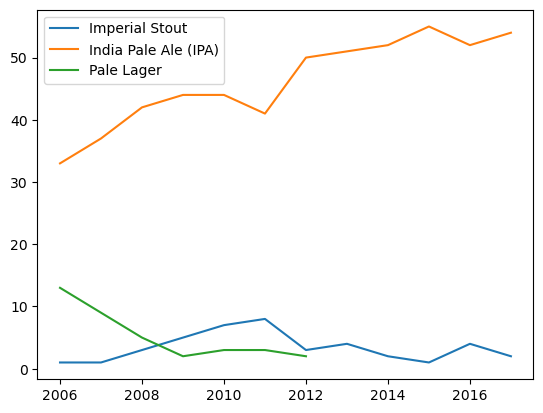

In [148]:
#No threshold, just number of ratings
plot_trend_nb(style_popularities_by_year, no_diff_columns)

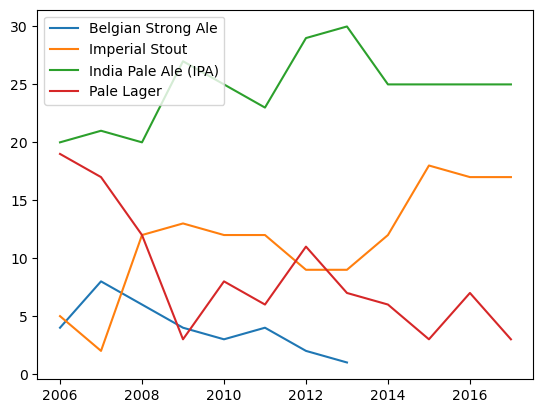

In [150]:
#Plot with threshold =0
plot_trend_nb(style_popularities_by_year_thr0, no_diff_columns)

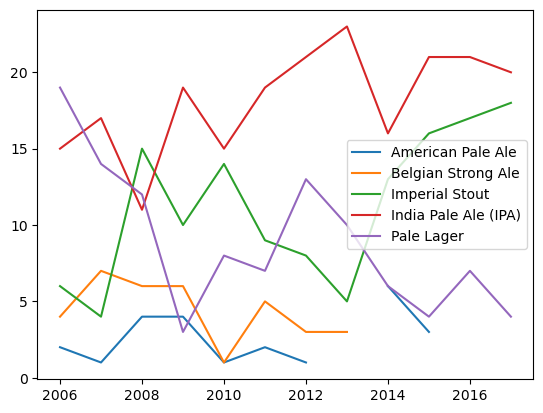

In [151]:
#Plot with threshold =0.5
plot_trend_nb(style_popularities_by_year_thr05, no_diff_columns)

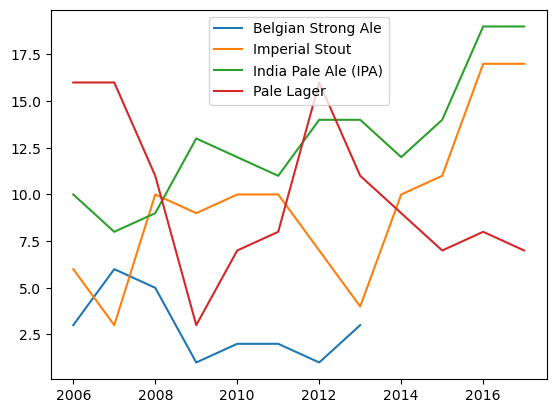

In [149]:
#Threshold = 1
plot_trend_nb(style_popularities_by_year_thr1, no_diff_columns)

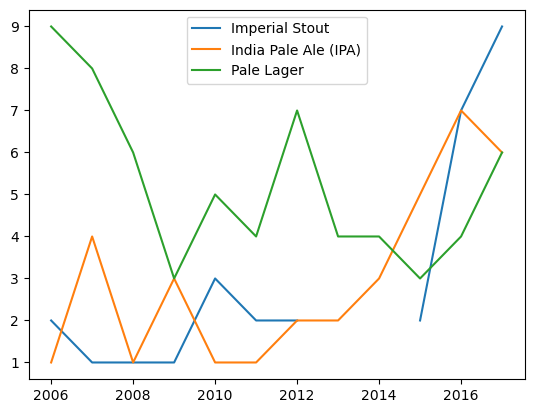

In [152]:
#Plot with threshold =3
plot_trend_nb(style_popularities_by_year_thr3, no_diff_columns)

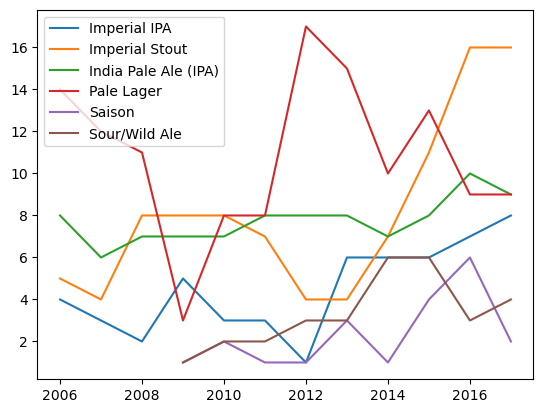

In [153]:

#Plot when popularity is only computed with the difference from global mean (preferred style = most different)


plot_trend_nb(popularity_by_difference, no_diff_columns)

In [34]:
#Try with threshold depending on the year ? Ex mean difference of the year?
#mean - 3*std 

#Get the mean difference for each year

years = np.arange(2006, 2018)
mean_difference_by_year = pd.DataFrame()
for year in years:
    
    location_style = location_style_stats(ratings.copy(), users.copy(), year, 5)
    
    mean_year = location_style['difference_percentage'].mean()
    
    mean_year= pd.DataFrame({'mean_difference': [mean_year]}, index = [year])
    mean_difference_by_year = pd.concat([mean_difference_by_year, mean_year], axis = 0)
    




[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
2006
    location               style  number  total_loc_number  \
0  Australia        Abbey Dubbel      11               856   
1  Australia        Abbey Tripel      15               856   
2  Australia       Abt/Quadrupel       7               856   
3  Australia           Amber Ale      16               856   
4  Australia  Amber Lager/Vienna      10               856   

   popularity_percentage  mean_rating  location_mean  location_std  \
0               1.285047     0.057760      -0.405756      1.191329   
1               1.752336     0.403658      -0.405756      1.191329   
2               0.817757     1.224202      -0.405756      1.191329   
3               1.869159    -0.610433      -0.405756      1.191329   
4               1.168224    -0.815467      -0.405756      1.191329   

   difference_percentage   z_score  
0              -0.201763  0.389075  
1              -0.507399  0.679421  
2              -0.288851  1.

In [ ]:
#mean_difference_by_year.to_csv('dataset/FilteredData/mean_difference_by_year.csv', index = True)

In [172]:
#Compute the stats by putting the threshold as the mean difference for the year 
#Remark : maybe too small (mean close to 0)
years = np.arange(2006, 2018)

yearly_stats = pd.DataFrame()
for year in years:
    location_style = all_infos
    location_style = location_style.loc[location_style['year'] == year]
    mean = mean_difference_by_year.loc[year]['mean_difference']
    location_style = location_style.loc[location_style['difference_percentage'] > mean]

    
    location_style_groupedby_loc = location_style.groupby('location')
    idx_most_popular = location_style_groupedby_loc['number'].idxmax()
    most_popular_styles_by_location = location_style.loc[idx_most_popular]
   
    most_popular_styles_by_location = most_popular_styles_by_location[['location', 'style', 'difference_percentage']]
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'difference_percentage': 'diff-'+str(year)})

    most_popular_styles_by_location.set_index('location', inplace = True)
    most_popular_styles_by_location = most_popular_styles_by_location.rename(columns = {'style': str(year)})
    
    yearly_stats = pd.concat([yearly_stats, most_popular_styles_by_location], axis = 1)

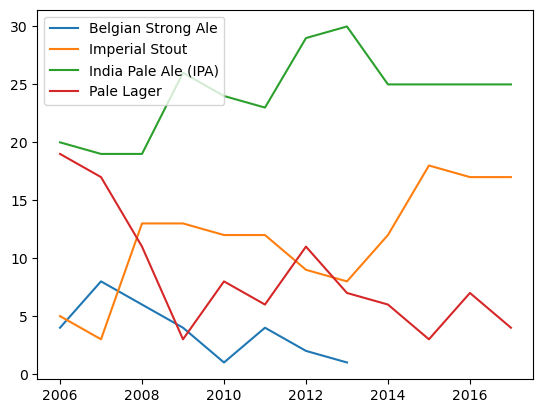

In [176]:
plot_trend_nb(yearly_stats, no_diff_columns)


Ratings for beer style


In [180]:
#Compmute the trends by setting a trend to be the biggest difference with global mean 

style_ratings_by_year_difference = compute_yearly_stats(0,'normalized_rating', do_thr = False,  study_ratings = True)

In [186]:
no_diff_columns_ratings = [col for col in style_ratings_by_year_difference.columns if col.startswith('2')]

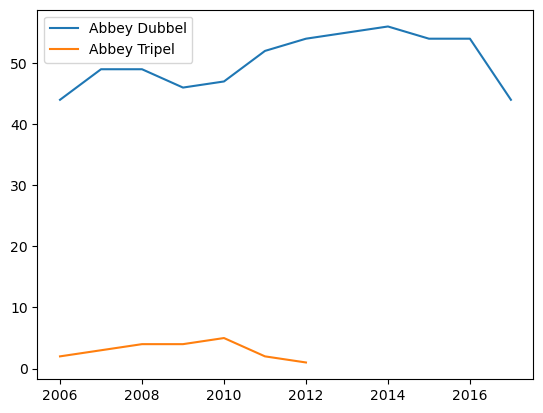

In [189]:
#Plot when popularity is only computed with the difference from global mean (preferred style = most different)
plot_trend_nb(style_ratings_by_year_difference, no_diff_columns_ratings)

In [182]:
style_ratings_by_year_z_score = compute_yearly_stats(0,'z_score', do_thr = False,  study_ratings = True)

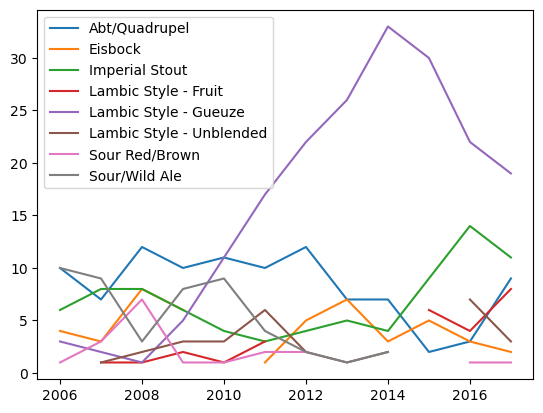

In [198]:
#Plot when popularity is only computed with the difference from global mean (preferred style = most different)
plot_trend_nb(style_ratings_by_year_z_score, no_diff_columns_ratings)

In [ ]:
#not at all the same now!
#And not the same as when we compute with number of ratings

<Axes: >

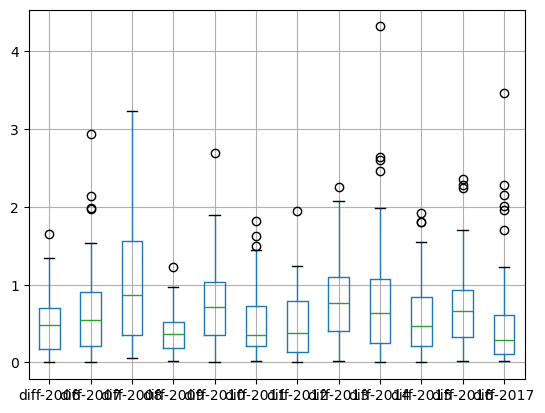

In [200]:
#Plot boxplot of the difference with global mean for each year, with preferred style (no threshold)
diff_columns = [col for col in style_ratings_by_year_z_score.columns if col.startswith('diff')]
style_ratings_by_year_z_score[diff_columns].boxplot()


In [ ]:
#Maybe weird that no negative value? maybe to check